In [ ]:
pip install catboost

In [ ]:
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [ ]:
train_data = pd.read_csv("train.csv")
train_data = train_data.drop("id", axis=1)

In [ ]:
train_data = pd.get_dummies(train_data, dtype=int, drop_first=True)

In [ ]:
train_data.head(4)

Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories  Sex_male
0   36   189.0    82.0      26.0       101.0       41.0     150.0         1
1   64   163.0    60.0       8.0        85.0       39.7      34.0         0
2   51   161.0    64.0       7.0        84.0       39.8      29.0         0
3   20   192.0    90.0      25.0       105.0       40.7     140.0         1

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Age         750000 non-null  int64  
 1   Height      750000 non-null  float64
 2   Weight      750000 non-null  float64
 3   Duration    750000 non-null  float64
 4   Heart_Rate  750000 non-null  float64
 5   Body_Temp   750000 non-null  float64
 6   Calories    750000 non-null  float64
 7   Sex_male    750000 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 45.8 MB


In [ ]:
train_data.describe().round()

Age    Height    Weight  Duration  Heart_Rate  Body_Temp  \
count  750000.0  750000.0  750000.0  750000.0    750000.0   750000.0   
mean       41.0     175.0      75.0      15.0        95.0       40.0   
std        15.0      13.0      14.0       8.0         9.0        1.0   
min        20.0     126.0      36.0       1.0        67.0       37.0   
25%        28.0     164.0      63.0       8.0        88.0       40.0   
50%        40.0     174.0      74.0      15.0        95.0       40.0   
75%        52.0     185.0      87.0      23.0       103.0       41.0   
max        79.0     222.0     132.0      30.0       128.0       42.0   

       Calories  Sex_male  
count  750000.0  750000.0  
mean       88.0       0.0  
std        62.0       0.0  
min         1.0       0.0  
25%        34.0       0.0  
50%        77.0       0.0  
75%       136.0       1.0  
max       314.0       1.0

In [ ]:
top_data = train_data[train_data["Calories"] > train_data["Calories"].quantile(0.95)]
top_data.head(5)

Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories  Sex_male
12   25   203.0    99.0      29.0       111.0       40.8     202.0         1
23   72   186.0    92.0      29.0        98.0       40.9     264.0         1
41   61   161.0    60.0      29.0       111.0       41.0     209.0         0
46   50   171.0    64.0      28.0       116.0       41.2     214.0         0
75   28   203.0   105.0      29.0       112.0       40.8     209.0         1

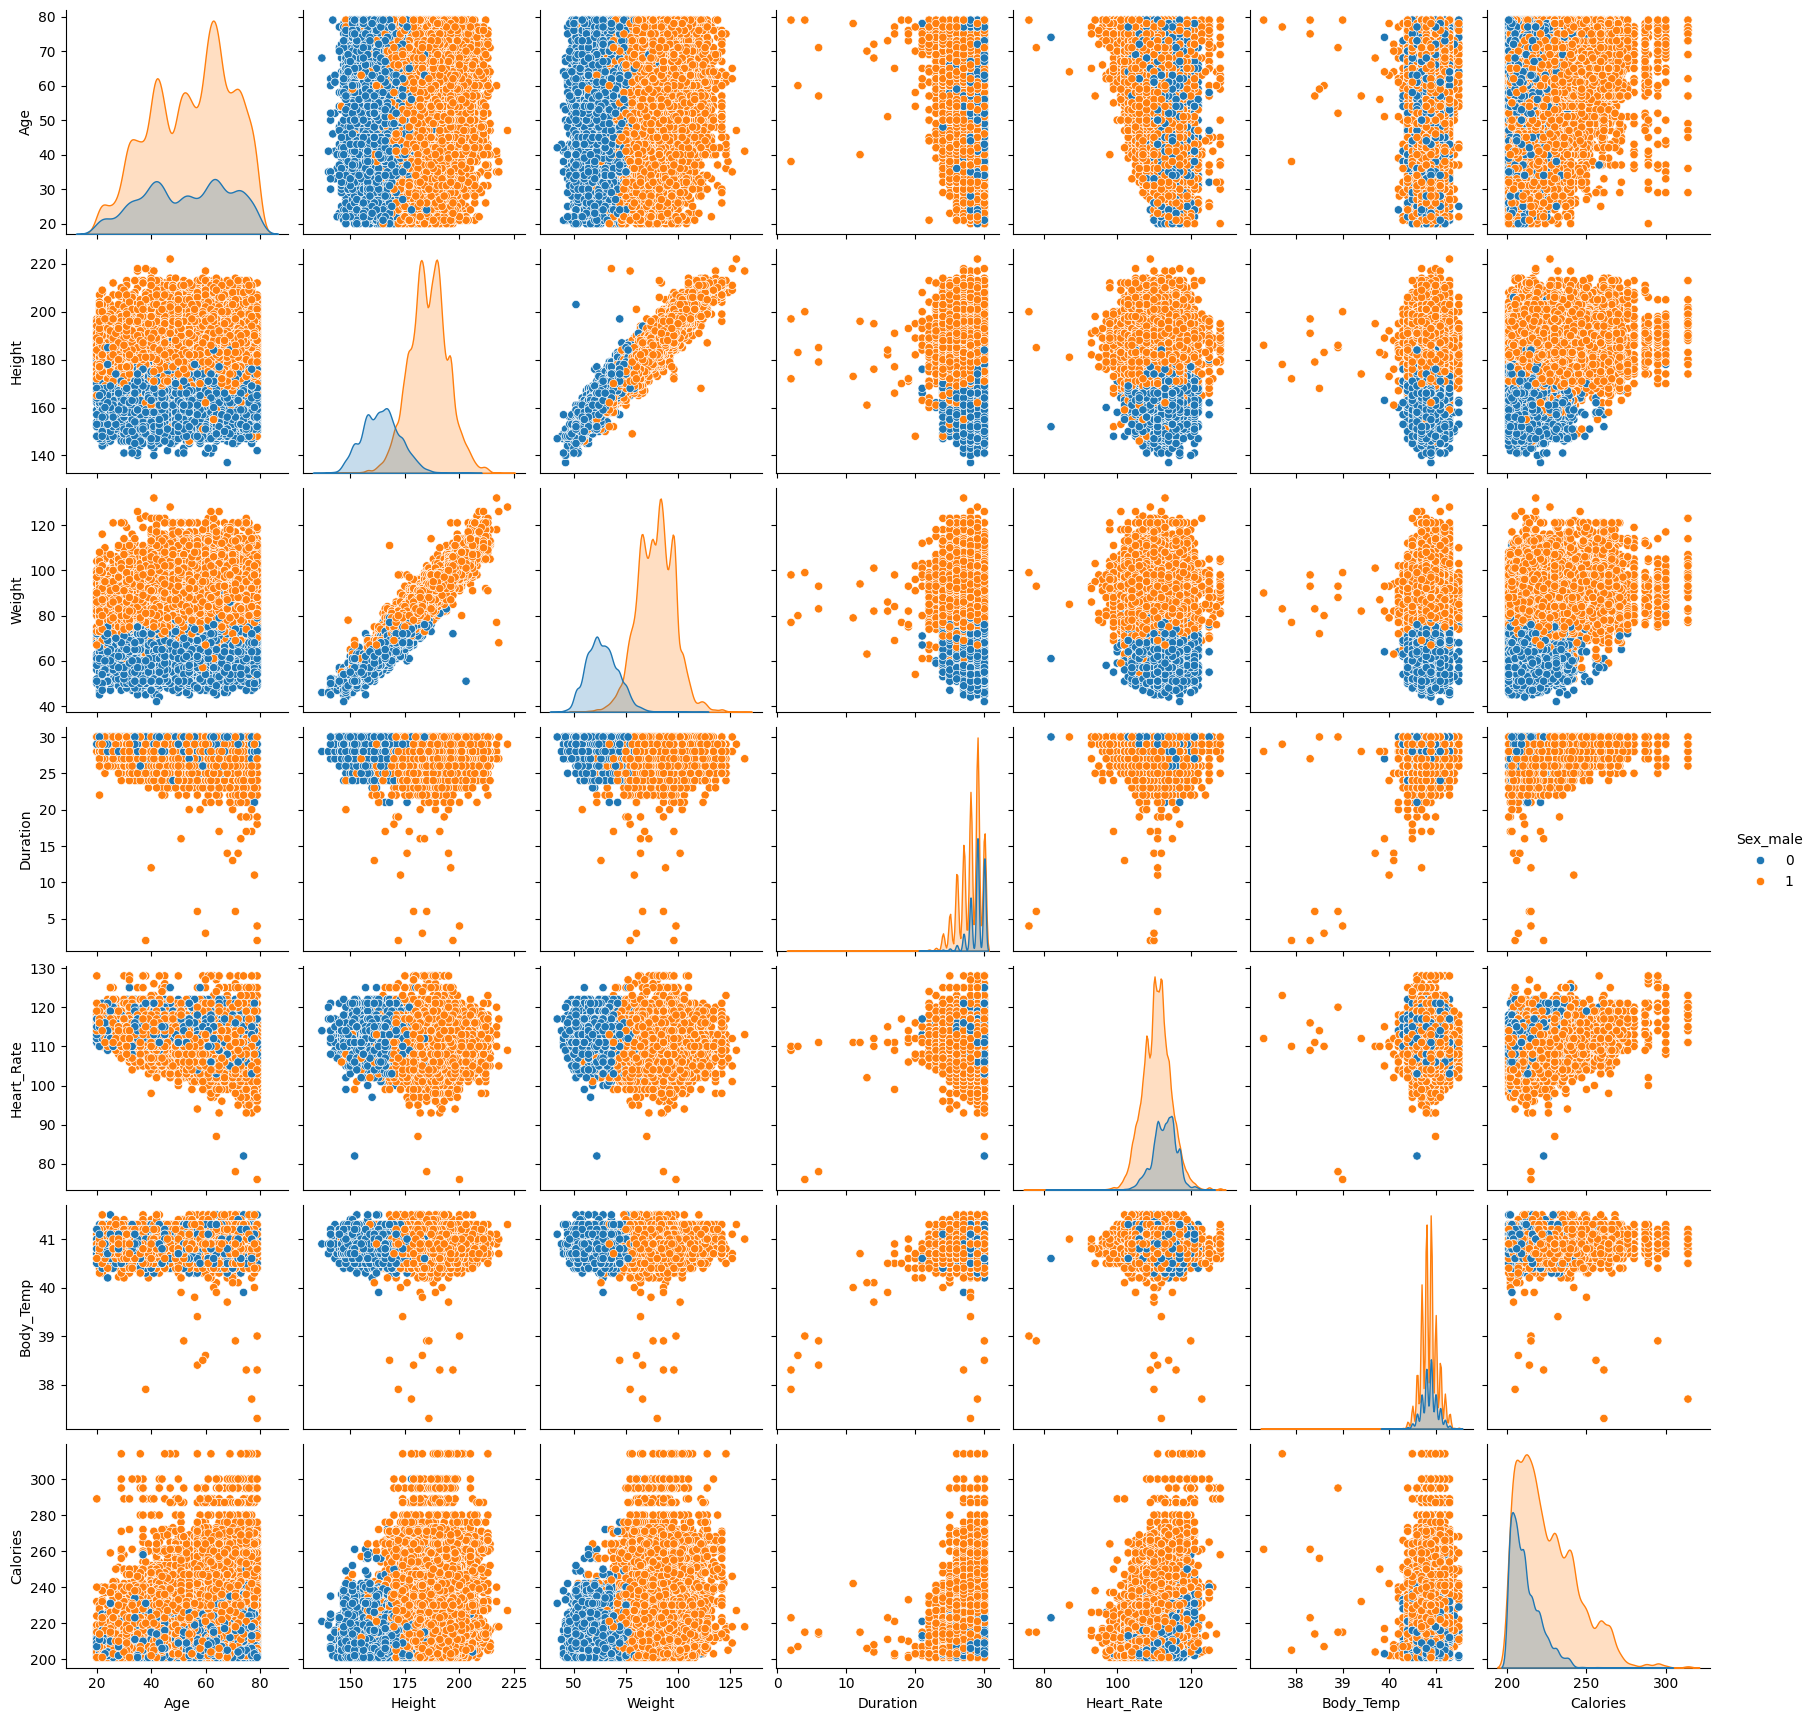

In [ ]:
sns.pairplot(top_data, hue="Sex_male")

<Axes: >

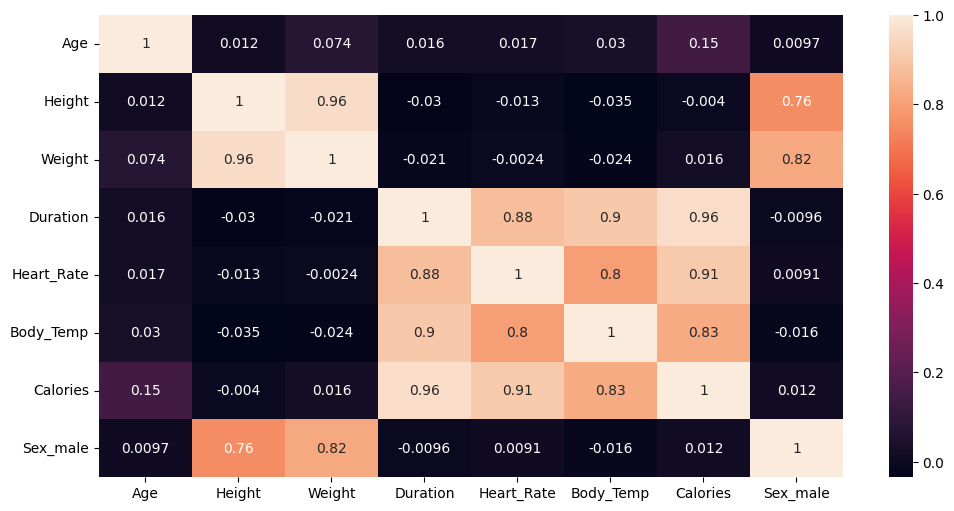

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=train_data.corr(), annot=True)

<Axes: >

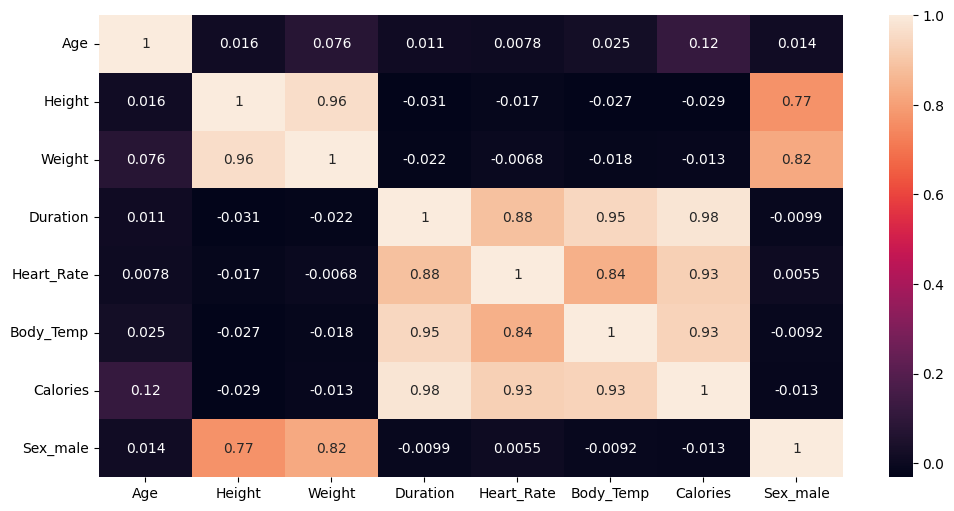

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=train_data.corr(method="spearman"), annot=True)

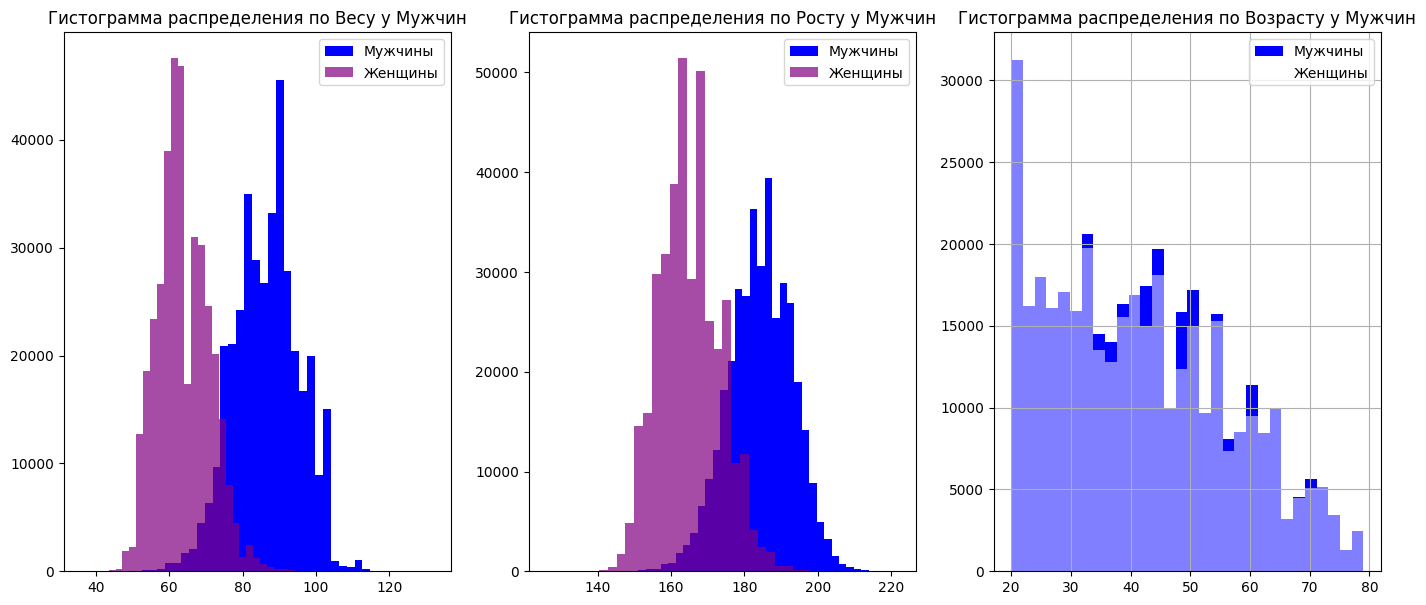

In [ ]:
plt.figure(figsize=(17, 7))
plt.subplot(1, 3, 1)
plt.title("Гистограмма распределения по Весу у Мужчин")
plt.hist(train_data["Weight"].loc[train_data["Sex_male"] == 1], bins=40, label="Мужчины", color = "blue")
plt.hist(train_data["Weight"].loc[train_data["Sex_male"] == 0], bins=40, label="Женщины", color="purple", alpha=0.7)
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Гистограмма распределения по Росту у Мужчин")
plt.hist(train_data["Height"].loc[train_data["Sex_male"] == 1], bins=40, label="Мужчины",color="blue")
plt.hist(train_data["Height"].loc[train_data["Sex_male"] == 0], bins=40, label="Женщины", color="purple", alpha=0.7)
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Гистограмма распределения по Возрасту у Мужчин")
plt.hist(train_data["Age"].loc[train_data["Sex_male"] == 1], bins=30, label="Мужчины", color="blue")
plt.hist(train_data["Age"].loc[train_data["Sex_male"] == 0], bins=30, label="Женщины", color="white", alpha=0.5)

plt.legend()
plt.grid(True)

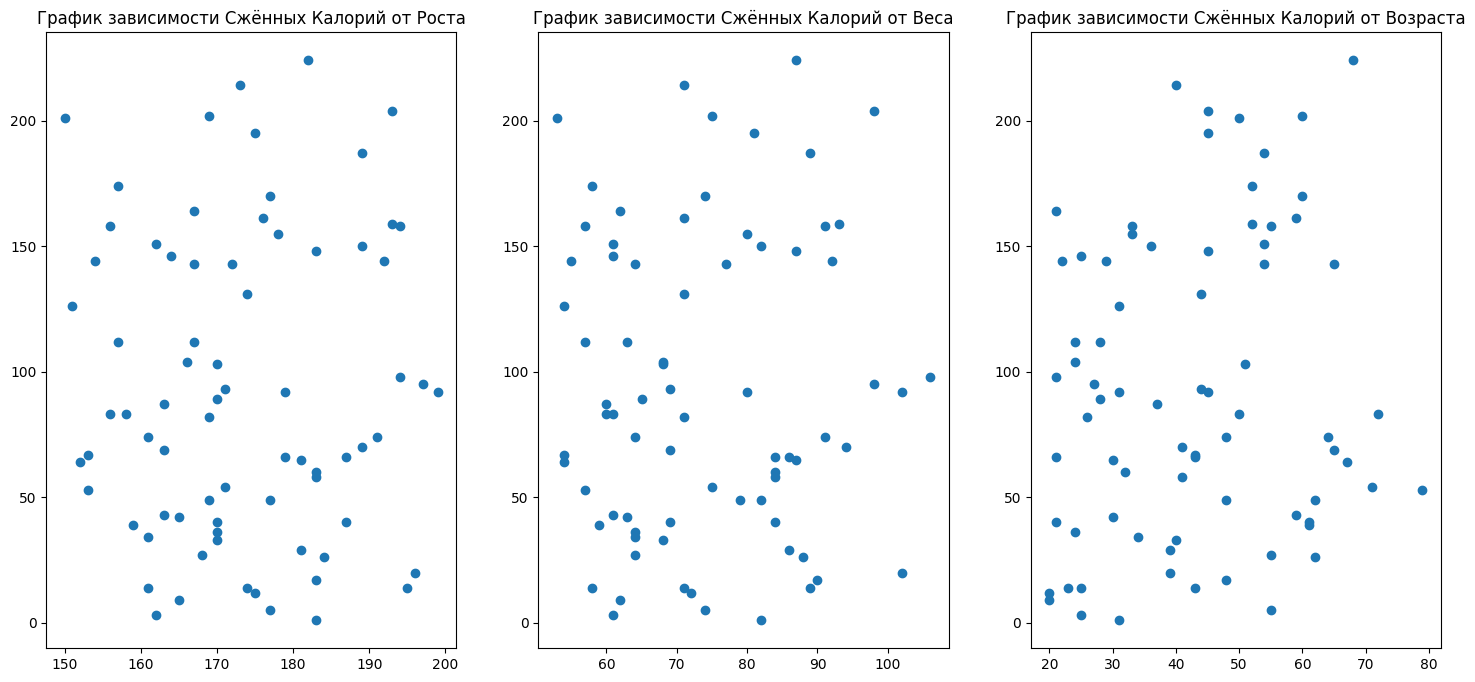

In [ ]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 3, 1)
plt.title("График зависимости Сжённых Калорий от Роста")
plt.scatter(train_data["Height"][::10000], train_data["Calories"][::10000])

plt.subplot(1, 3, 2)
plt.title("График зависимости Сжённых Калорий от Веса")
plt.scatter(train_data["Weight"][::10000], train_data["Calories"][::10000])

plt.subplot(1, 3, 3)
plt.title("График зависимости Сжённых Калорий от Возраста")
plt.scatter(train_data["Age"][::10000], train_data["Calories"][::10000])

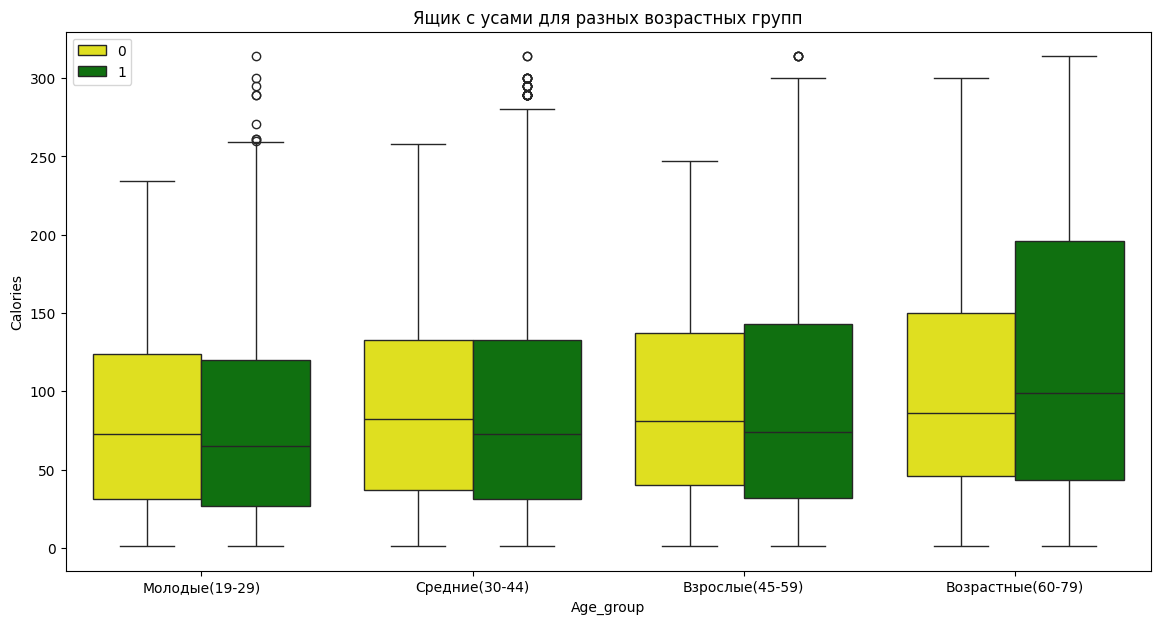

In [ ]:
plt.figure(figsize=(14, 7))
bins = [19, 30, 45, 60, 79]
train_data["Age_group"] = pd.cut(train_data["Age"], bins=bins, labels=["Молодые(19-29)", "Средние(30-44)","Взрослые(45-59)", "Возрастные(60-79)"])
sns.boxplot(x="Age_group", y="Calories", data=train_data, hue="Sex_male", palette=["yellow", "green"])
plt.title("Ящик с усами для разных возрастных групп")
a = plt.legend()
#plt.grid(True)

In [ ]:
train_data.iloc[[0, 1000], [0, 1, 2, 3 ,4, 8]]

Age  Height  Weight  Duration  Heart_Rate       Age_group
0      36   189.0    82.0      26.0       101.0  Средние(30-44)
1000   21   169.0    64.0      15.0        94.0  Молодые(19-29)

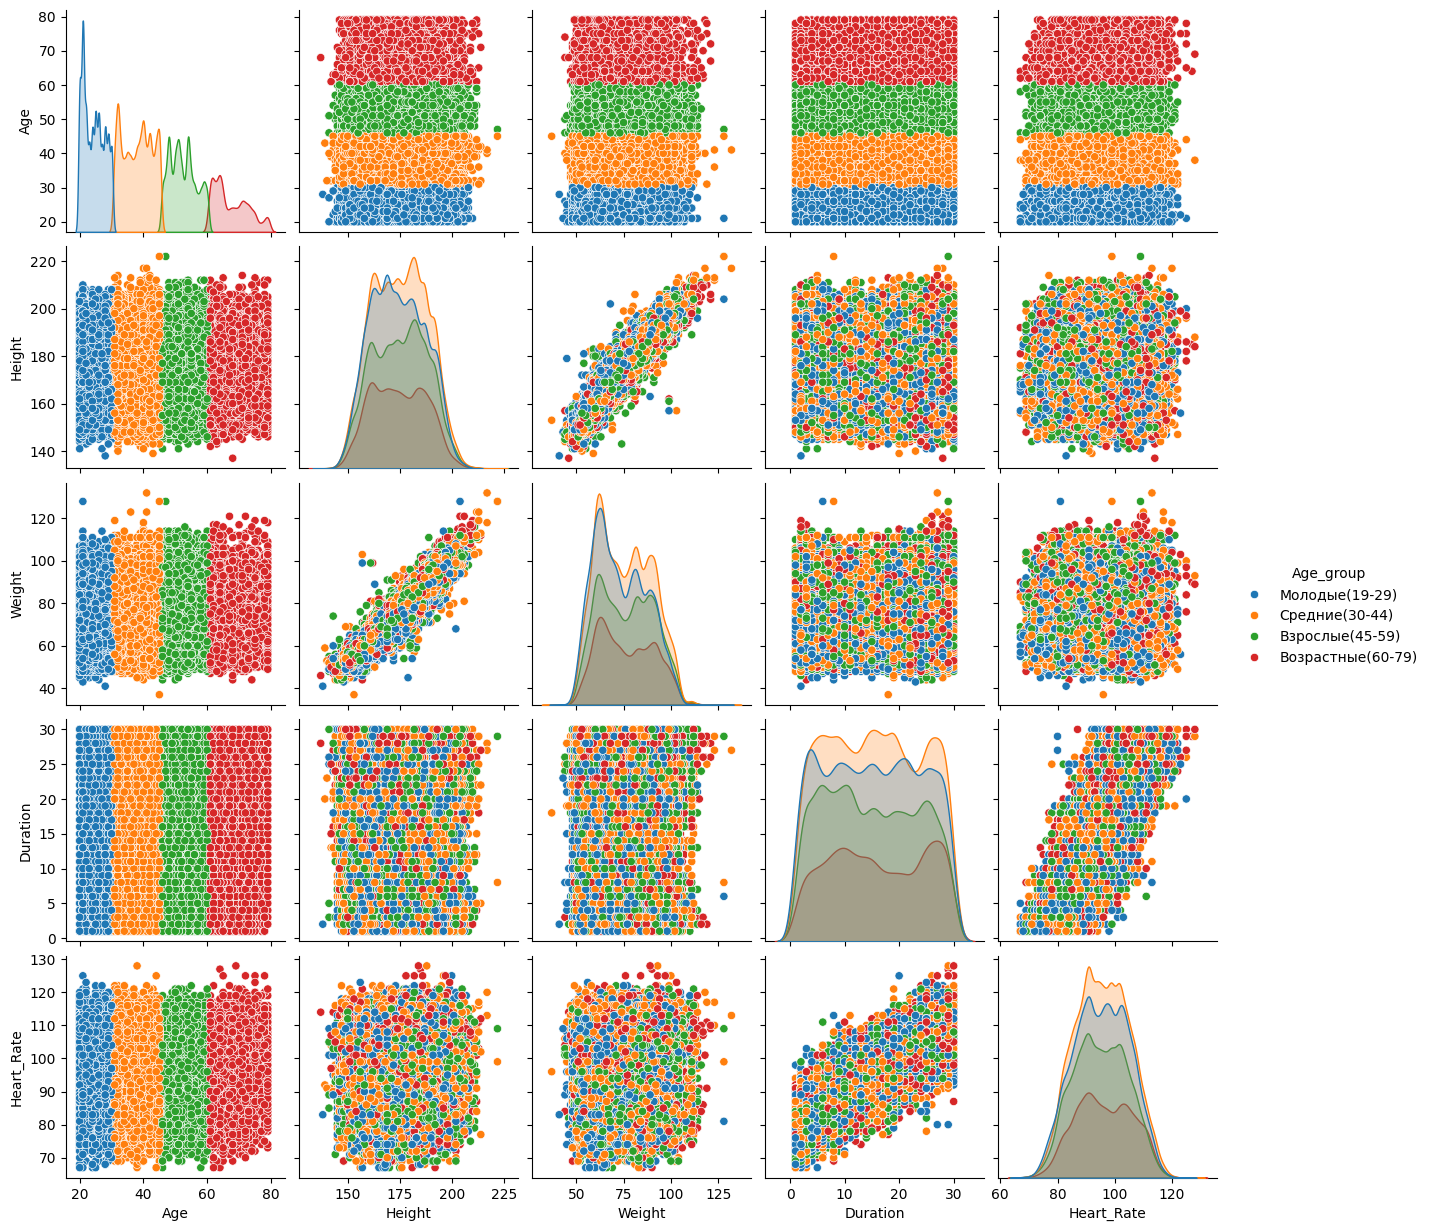

In [ ]:
#sns.pairplot(train_data.loc[train_data["Age"], train_data["Height"], train_data["Weight"], train_data["Duration"]], hue="Age_group")
sns.pairplot(train_data.iloc[0:100000, [0, 1, 2, 3 ,4, 8]], hue="Age_group")

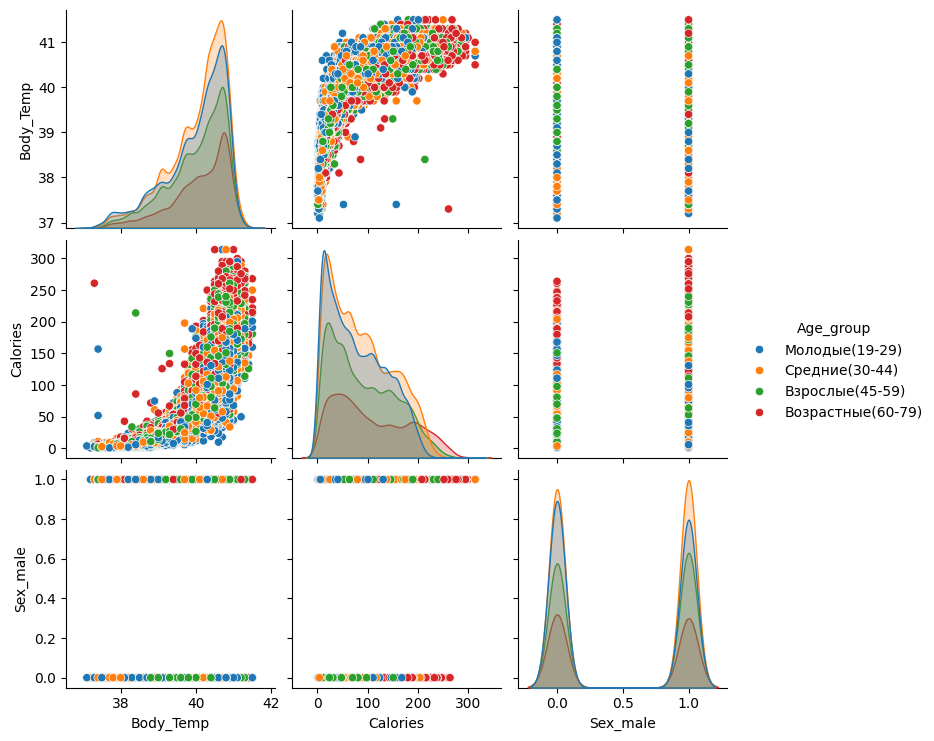

In [ ]:
sns.pairplot(train_data.iloc[0:100000, 5:], hue="Age_group")

#FEATURE ENGINEERING

In [ ]:
train_data.head(3)

Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories  Sex_male  \
0   36   189.0    82.0      26.0       101.0       41.0     150.0         1   
1   64   163.0    60.0       8.0        85.0       39.7      34.0         0   
2   51   161.0    64.0       7.0        84.0       39.8      29.0         0   

           Age_group  
0     Средние(30-44)  
1  Возрастные(60-79)  
2    Взрослые(45-59)

In [ ]:
OHE = OneHotEncoder(sparse_output = False).set_output(transform="pandas")

def feature_engineering(df):
    #df["CalPerMinute"] = df["Calories"]/df["Duration"] #Количество сожжённых калорий в минуту
    df["IndMassBody"] = df["Weight"]/(df["Height"]/10 * df["Height"]/10) #Индекс массы тела
    df["bigLossByWeight"] = df["Weight"] * df["Duration"] #Чем больше вес, тем больше тратится каллорий при одинаковой нагрузке
    df['Age'] = np.log1p(df['Age']) #Сглаживаем возраст
    df["Intencity"] = df["Heart_Rate"] * df["Duration"]
    df["AgeValue"] = df["Age"] * df["Duration"]
    df["MegaIntencity"] = df["Duration"] * df["Body_Temp"] * df["Heart_Rate"]
    ohetrans = OHE.fit_transform(df[["Age_group"]])
    df = pd.concat([df, ohetrans], axis=1).drop(columns=["Age_group"])
    return df
train_data = feature_engineering(train_data)

In [ ]:
train_data.sample(3)

Age  Height  Weight  Duration  Heart_Rate  Body_Temp  Calories  \
333497  3.850148   193.0    98.0      29.0       114.0       40.6     227.0   
557947  3.951244   161.0    55.0      21.0        92.0       40.5     104.0   
71524   3.496508   174.0    75.0      21.0        93.0       40.6      89.0   

        Sex_male  IndMassBody  bigLossByWeight  Intencity    AgeValue  \
333497         1     0.263094           2842.0     3306.0  111.654280   
557947         0     0.212183           1155.0     1932.0   82.976118   
71524          1     0.247721           1575.0     1953.0   73.426659   

        MegaIntencity  Age_group_Взрослые(45-59)  Age_group_Возрастные(60-79)  \
333497       134223.6                        1.0                          0.0   
557947        78246.0                        1.0                          0.0   
71524         79291.8                        0.0                          0.0   

        Age_group_Молодые(19-29)  Age_group_Средние(30-44)  
333497                       0.0                       0.0  
557947                       0.0                       0.0  
71524                        0.0                       1.0

In [ ]:
train_data_y = train_data["Calories"]
train_data_x = train_data.drop("Calories", axis=1)
X_train, X_test, y_train, y_test = train_test_split(train_data_x, train_data_y, test_size=0.2, random_state=42)

In [ ]:
def rmsle(y_val_log, y_pred_log):
    y_val = np.expm1(y_val_log)
    y_pred = np.expm1(y_pred_log)
    preds = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_val, preds))

In [ ]:
lgbm_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 64,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt'
}

model=LGBMRegressor(**lgbm_params)

LGBMRegressor:
Mean Squared Error: 12.925089961811715
Root Mean Squared Log Error: 0.003565606868686335
R² Score: 0.9966650227565916
RMSLE: 3.5951481140297563


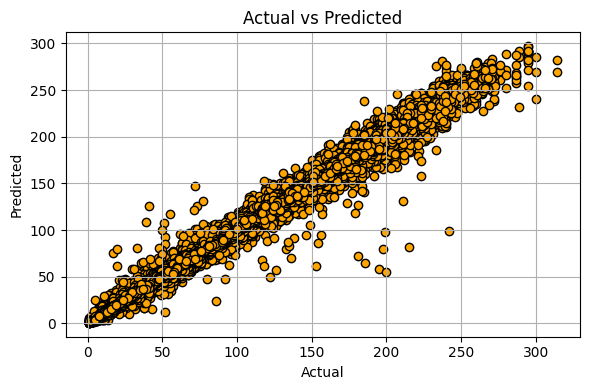

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"LGBMRegressor:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Log Error:", mean_squared_log_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))
print("RMSLE:", rmsle(y_test, y_pred))

plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, color="orange", edgecolor="black")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test_data = pd.read_csv("test.csv")
test_data = test_data.drop("id", axis=1)
test_data = pd.get_dummies(test_data, dtype=int, drop_first=True)

bins = [19, 30, 45, 60, 79]
test_data["Age_group"] = pd.cut(test_data["Age"], bins=bins, labels=["Молодые(19-29)", "Средние(30-44)","Взрослые(45-59)", "Возрастные(60-79)"])
test_data = feature_engineering(test_data)

sub = pd.read_csv("sample_submission.csv")
sub["Calories"] = model.predict(test_data)
sub.to_csv("answer.csv", index=False)